In [1]:

import vtk
import os
import numpy as np
import itertools
import math, random
import pointnetfunct.data_process_ml as data_process_ml
random.seed = 42
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch import optim
from pointnetfunct.PointNet_struct import Tnet,Transform,PointNet,PointNet_2Multihead,PointNet_3Multihead

import scipy.spatial.distance
# import plotly.graph_objects as go
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pointnetfunct.PointNet_trainingfunct import run_model_get,run_model_3multi_head_dnn,run_model_2multi_head_dnn,load_model
from pointnetfunct.PointNet_struct import PointNet,PointNet_2Multimodal_withDNN,PointNet_3Multihead_withDNN

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pointnetfunct.functions as fun

from torch.utils.data import Subset
from pointnetfunct.evaluation import show_graph
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph



load the dataset

In [2]:
import pandas as pd
from pointnetfunct.PointNet_dataset import Aneux_Dataset_load
df = pd.DataFrame()
# Aneux_Dataset = Aneuxmodel_Dataset(root = root,
#                                    df=morpho_data_patient[morpho_data_patient["cuttype"] == "dome"],
#                                    transform = transforms.ToTensor(),
#                                    mesh = "area-001",
#                                    cuttype = "dome",
#                                    crop = False)

Aneux_Dataset = Aneux_Dataset_load('./Datasets/Aneux_Dataset_2000pt_sample_600train.pt')
Aneux_Dataset.paraout = True
Aneux_Dataset_test = Aneux_Dataset_load('./Datasets/Aneux_Dataset_2000pt_sample_100test.pt')
Aneux_Dataset.cuttype = "cut1"
Aneux_Dataset_test.cuttype = "cut1"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\pointnetfunct\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

In [3]:


#1916614438200
seed = torch.seed()
print(seed)
torch.manual_seed(32381912834800)

train_size = int(len(Aneux_Dataset) * 0.85) # 80% training data
valid_size = len(Aneux_Dataset) - train_size
train_data, valid_data = random_split(Aneux_Dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=50,
    shuffle=True,
    #num_workers=2, 
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    Aneux_Dataset_test,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

4198877441200


Test vaildation

# PointNet model

Multi head

In [4]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.act_func = F.gelu
        self.pooling = nn.MaxPool3d

    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = self.act_func(self.bn1(self.conv1(input)))
        xb = self.act_func(self.bn2(self.conv2(xb)))
        xb = self.act_func(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = self.act_func(self.bn4(self.fc1(flat)))
        xb = self.act_func(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform_2Multi(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,512,1)
        
        self.fc1 = nn.Linear(3,64)
        self.fc2 = nn.Linear(64,64)
        
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,128)
        self.fc5 = nn.Linear(128,1024)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.bn4 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(64)

    def forward(self, input):
        
        matrix3x3 = self.input_transform(input)
        xb = input
        # batch matrix multiplication

        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        #print(xb.size())
        #print(xb)

        xb = F.relu(self.bn1(self.conv1(xb)))
        # xb = F.relu(self.bn4(self.fc1(xb)))
        # xb = F.relu(self.bn5(self.fc2(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)
        # print(xb.size())

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        

        
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64
    

class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(DNNModel, self).__init__()

        # Define layers
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.loss_fn = nn.CrossEntropyLoss()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        
        #Adam
        #self.optimizer = optim.Adam(self.parameters(), lr=0.00001) #weight decay
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        self.running_loss = 0
        self.loss = None
        self.losses = []

    def forward(self, x, target =None):
        # Forward pass
        #x = self.Flatten(x)
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

    
class PointNet_2Branch(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.transform2 = Transform_2Multi()
        self.transform3 = DNNModel(172,512,256,128)
        
        self.fc1 = nn.Linear(640, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.optimizer = optim.Adam(self.parameters(), lr=0.00001)
        #self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([0.4,0.6]))
        self.running_loss = 0
        self.loss = None
        self.losses = []

    def forward(self, input1, input2):
        #xb, matrix3x3, matrix64x64 = self.transform(input)
        xa, matrix3x3, matrix64x64 = self.transform2(input1)
        xb = self.transform3(input2)
        
        
        xd = torch.cat((xa, xb), dim=1)
        xd = F.relu(self.bn1(self.fc1(xd)))
        xd = F.relu(self.bn2(self.dropout(self.fc2(xd))))
        output = self.fc3(xd)
        return self.logsoftmax(output)
    
    def fit(self, input1, input2, targets):
        #train/optimize/fit
        #print(x.size)
        # x = x.to(torch.float32)
        input1 = input1.squeeze(1).permute(0, 2, 1)
        targets = targets.to(torch.long)
        #print(targets)
        preds = self.forward(input1,input2)
        #print(targets.dtype)
        self.loss = self.loss_fn(preds, targets)
        self.loss.backward()
        self.optimizer.step()
        
        loss_item = self.loss.item()
        return loss_item


    def reset_loss(self, value):
        self.running_loss = value
        self.losses = []
        return

2branch multimodal

In [5]:
name = "2branch_Tnet_without_2fcl"

In [6]:
from pointnetfunct.PointNet_struct import PointNet_2Multimodal_withDNN

pointnet_2mh = PointNet_2Multimodal_withDNN(classes=2)
run_model_2multi_head_dnn(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_2mh,
                        results_path = "./2branch_cut1_uniform_2000pt_abtest", 
                        filename = "/"+name + ".pt",
                        model_name="./2branch_cut1_uniform_2000pt_abtest/"+ name + ".pth")
pointnet_2mh.to("cpu")


epoch: 0 training loss:  0.697 training accuracy:  60.5%  test loss:  0.669 test accuracy:  60.4%
epoch: 1 training loss:  0.667 training accuracy:  65.3%  test loss:  0.636 test accuracy:  75.0%
epoch: 2 training loss:  0.666 training accuracy:  69.8%  test loss:  0.611 test accuracy:  74.0%
epoch: 3 training loss:  0.636 training accuracy:  69.8%  test loss:  0.627 test accuracy:  77.1%
epoch: 4 training loss:  0.631 training accuracy:  72.4%  test loss:  0.576 test accuracy:  78.1%
epoch: 5 training loss:  0.614 training accuracy:  69.2%  test loss:  0.581 test accuracy:  75.0%
epoch: 6 training loss:  0.597 training accuracy:  74.4%  test loss:  0.577 test accuracy:  78.1%
epoch: 7 training loss:  0.564 training accuracy:  74.0%  test loss:  0.563 test accuracy:  79.2%
epoch: 8 training loss:  0.613 training accuracy:  72.2%  test loss:  0.520 test accuracy:  79.2%
epoch: 9 training loss:  0.585 training accuracy:  72.9%  test loss:  0.528 test accuracy:  77.1%
epoch: 10 training l

PointNet_2Multimodal_withDNN(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64,

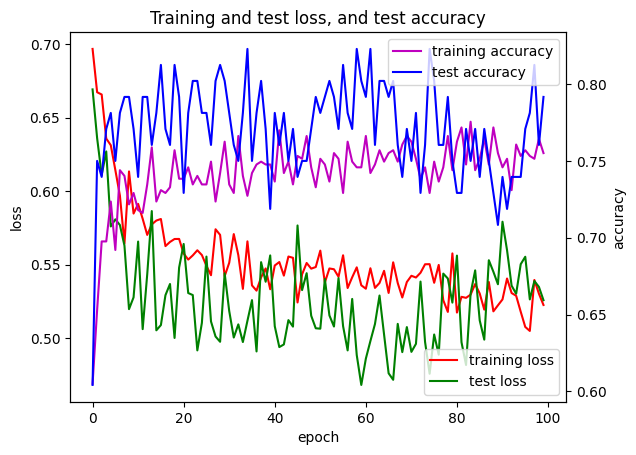

In [7]:
show_graph("./2branch_cut1_uniform_2000pt_abtest/"+name + ".pt",device="cuda")

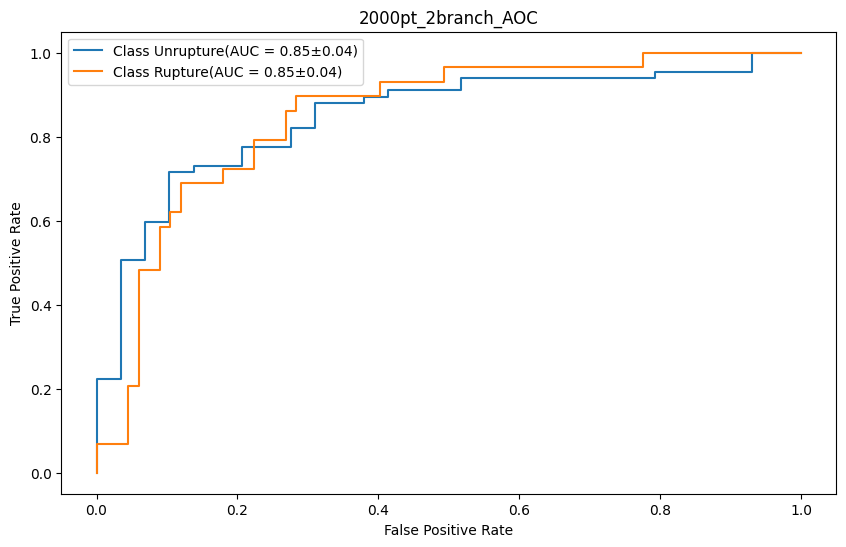

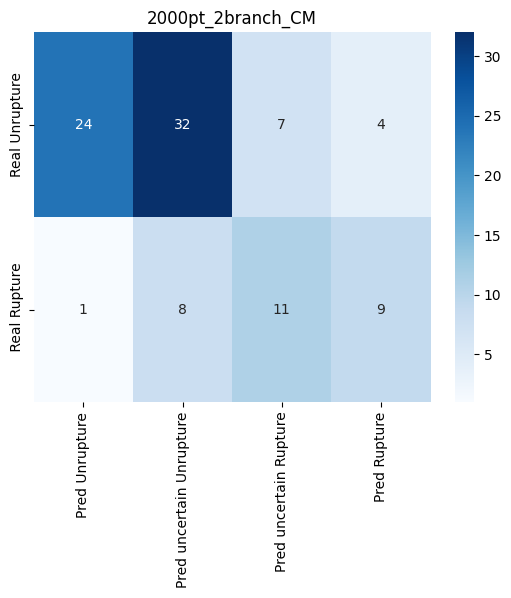

Accuracy: 0.7916666666666666
F1 score: 0.6666666666666667
Rupture Recall: 0.6896551724137931
Rupture Precision: 0.6451612903225806
UnRupture Recall: 0.835820895522388
UnRupture Precision: 0.8615384615384616


In [8]:
pointnet_2mh.to("cpu")
pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
model_path = "./2branch_cut1_uniform_2000pt_abtest/"+name +".pth"
#pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
# model_path = "./final_models/2000points/cut1/pointnet_cut1_2branch_uniform_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)
        
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_2branch_CM")
print_values (y_true, y_pred_result)

In [9]:
device = "cuda"
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            inputs_v, labels = data
            
            loss_fn = nn.CrossEntropyLoss()

            #to work with gpu you will need to load data and labels to gpu
            inputs_v = inputs_v.to(device)
            labels = labels.to(device)
            
            inputs_v = inputs_v.to(torch.float32)
            labels = labels.to(torch.long)

            outputs = net.forward(inputs_v)

            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

    return running_loss/n, correct/total


# run model
def run_model_get(train_loader_input,vaild_loader_input,nepochs, modelnet,results_path, filename, transform = None,dataset =None):
    os.makedirs(results_path, exist_ok = True)
    saveCkpt = results_path + filename
    statsrec = np.zeros((4,nepochs))
    modelnet = modelnet.to(device)
    max_atst = 0
    mini_loss = 100
    for epoch in range(nepochs):  # loop over the dataset multiple times
        correct = 0          # number of examples predicted correctly (for accuracy)
        total = 0            # number of examples
        epoch_loss = 0.0   # accumulated loss (for mean loss)
        n = 0
        
        if transform != None:
            dataset.transform_image(transform)  
                        
        for data in train_loader_input:
            inputs, labels = data
            #print(inputs, labels)
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            #print(labels)
            modelnet.optimizer.zero_grad()
            # Forward, backward, and update parameters
            loss = modelnet.fit(inputs, labels) # note: .to(device) helps to load data to your gpu
            # accumulate loss
            epoch_loss += loss
            n += 1
            outputs = modelnet.forward(inputs)
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

        # collect together statistics for this epoch
        ltrn = epoch_loss/n
        atrn = correct/total
        ltst, atst = stats(vaild_loader_input, modelnet)

        ltst = ltst.item() #item() moves the tensor data with 1 element to CPU

        statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
        
        # if atst > max_atst:
        #     model_path = "DNN_dome_lr0.0001_epoch_test.pth"
        #     torch.save(modelnet.state_dict(), model_path)
        #     max_atst = atst
        if ltst < mini_loss:
            model_path = "DNN_dome_lr0.0001_epoch_test.pth"
            torch.save(modelnet.state_dict(), model_path)
            mini_loss = ltst

    # save network parameters, losses and accuracy
    torch.save({"state_dict": modelnet.state_dict(), "stats": statsrec}, saveCkpt)

In [10]:
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, output_size):
        super(DNNModel, self).__init__()

        # Define layers
        self.Flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.loss_fn = nn.CrossEntropyLoss(weight = torch.tensor([0.4,0.6]))
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)
        
        #Adam
        #self.optimizer = optim.Adam(self.parameters(), lr=0.001) #weight decay
        self.optimizer = optim.SGD(self.parameters(), lr=0.001)
        self.running_loss = 0
        self.loss = None
        self.losses = []

    def forward(self, x, target =None):
        # Forward pass
        #x = self.Flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
    def fit(self, x, targets):
        #train/optimize/fit
        preds = self.forward(x)
        #print(preds, targets)
        self.loss = self.loss_fn(preds, targets.long())
        self.loss.backward()
        self.optimizer.step()
        
        loss_item = self.loss.item()
        return loss_item


    def reset_loss(self, value):
        self.running_loss = value
        self.losses = []
        return

In [11]:

Aneux_Dataset.pd_out = True
DNN3Fcl = DNNModel(172,256,128,2)
run_model_get(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = DNN3Fcl,
                        results_path = "./result", 
                        filename = "./DNN_test.pt")

Aneux_Dataset.pd_out = False

epoch: 0 training loss:  1.043 training accuracy:  52.1%  test loss:  0.747 test accuracy:  50.0%
epoch: 1 training loss:  0.831 training accuracy:  61.4%  test loss:  1.627 test accuracy:  42.7%
epoch: 2 training loss:  0.808 training accuracy:  57.5%  test loss:  1.452 test accuracy:  41.7%
epoch: 3 training loss:  0.895 training accuracy:  61.0%  test loss:  0.846 test accuracy:  42.7%
epoch: 4 training loss:  0.953 training accuracy:  61.2%  test loss:  0.672 test accuracy:  75.0%
epoch: 5 training loss:  0.751 training accuracy:  59.7%  test loss:  0.638 test accuracy:  69.8%
epoch: 6 training loss:  0.802 training accuracy:  63.1%  test loss:  0.961 test accuracy:  42.7%
epoch: 7 training loss:  0.731 training accuracy:  63.6%  test loss:  0.620 test accuracy:  69.8%
epoch: 8 training loss:  0.706 training accuracy:  64.9%  test loss:  0.617 test accuracy:  69.8%
epoch: 9 training loss:  0.696 training accuracy:  64.7%  test loss:  0.595 test accuracy:  69.8%
epoch: 10 training l

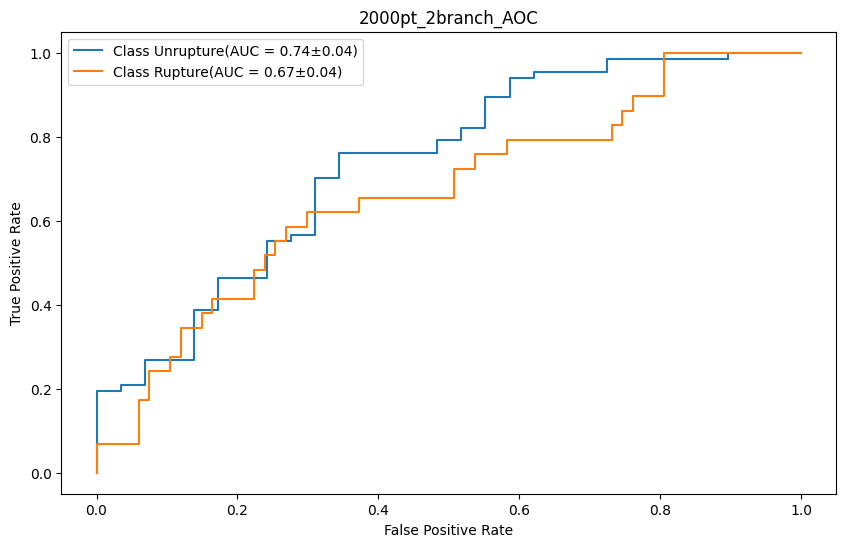

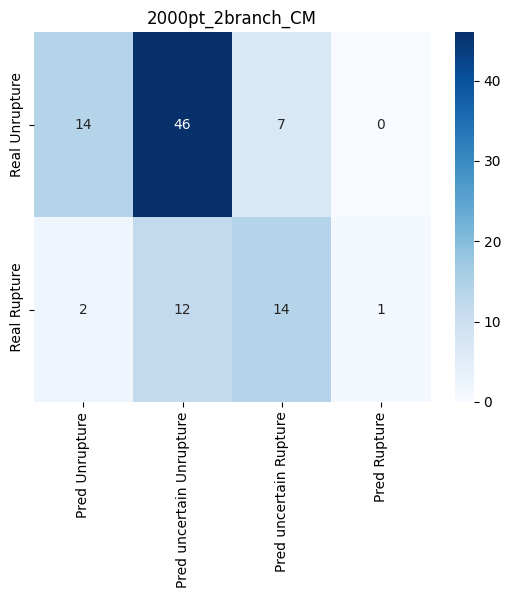

Accuracy: 0.78125
F1 score: 0.5882352941176471
Rupture Recall: 0.5172413793103449
Rupture Precision: 0.6818181818181818
UnRupture Recall: 0.8955223880597015
UnRupture Precision: 0.8108108108108109


In [12]:
DNN3Fcl.to("cpu")
DNN3Fcl = DNNModel(172,256,128,2)
model_path = "./DNN_dome_lr0.0001_epoch_test.pth"
#pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
# model_path = "./final_models/2000points/cut1/pointnet_cut1_2branch_uniform_2000pt.pth"
load_model(DNN3Fcl,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
DNN3Fcl = DNN3Fcl.to("cpu")
Aneux_Dataset.pd_out = True
with torch.no_grad():
    for inputs,labels in valid_loader:
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
            
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        
        labels = labels.to(torch.long)
        outputs = DNN3Fcl.forward(inputs)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)
Aneux_Dataset.pd_out = False
from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_2branch_CM")
print_values (y_true, y_pred_result)

In [13]:
name = name

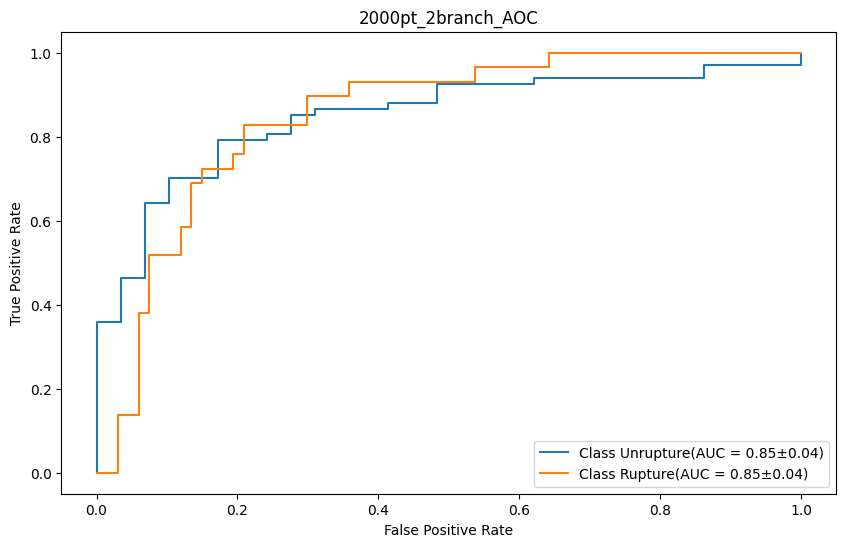

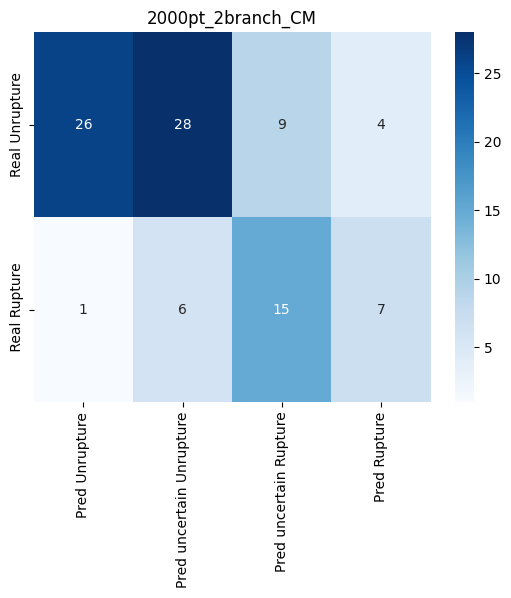

Accuracy: 0.7916666666666666
F1 score: 0.6875
Rupture Recall: 0.7586206896551724
Rupture Precision: 0.6285714285714286
UnRupture Recall: 0.8059701492537313
UnRupture Precision: 0.8852459016393442


In [14]:

pointnet_2mh.to("cpu")
pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
model_path = "./2branch_cut1_uniform_2000pt_abtest/"+name +".pth"
#pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
# model_path = "./final_models/2000points/cut1/pointnet_cut1_2branch_uniform_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)
        
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_2branch_CM")
print_values (y_true, y_pred_result)

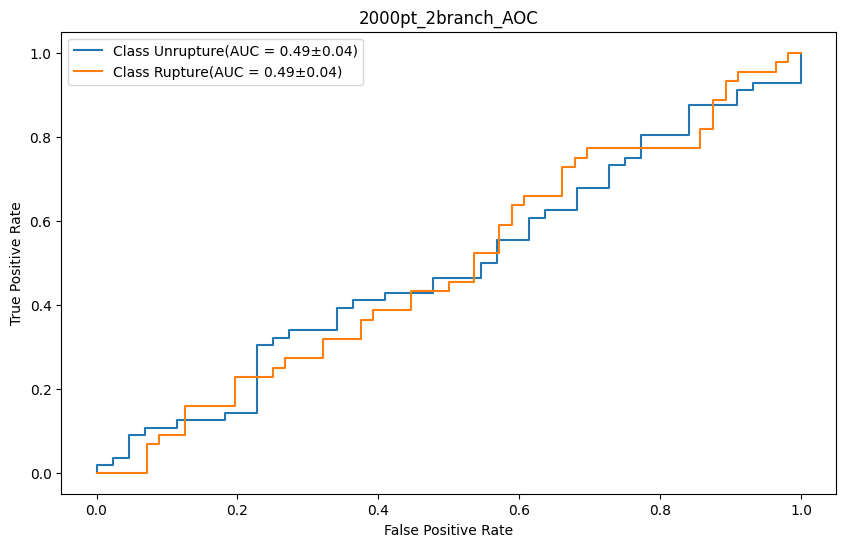

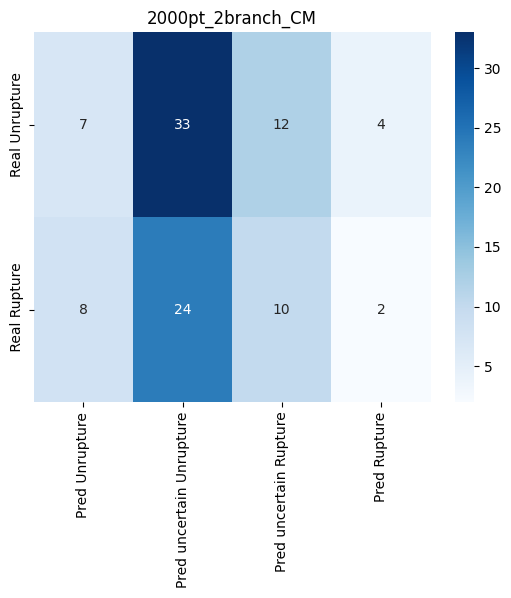

Accuracy: 0.52
F1 score: 0.33333333333333326
Rupture Recall: 0.2727272727272727
Rupture Precision: 0.42857142857142855
UnRupture Recall: 0.7142857142857143
UnRupture Precision: 0.5555555555555556


In [15]:

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)
        
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_2branch_CM")
print_values (y_true, y_pred_result)

3multihead

In [16]:
import functions
pointnet_3mh = PointNet_3Multihead_withDNN(classes=2)
# run_model_3multi_head_dnn(train_loader_input = train_loader,
#                         vaild_loader_input = valid_loader,
#                         nepochs = 100, 
#                         modelnet = pointnet_3mh,
#                         results_path = "./result", 
#                         filename = "/3multibranch_2000pt_test.pt",
#                         model_name="pointnet_3branch_modal_2000pt.pth")

ModuleNotFoundError: No module named 'functions'

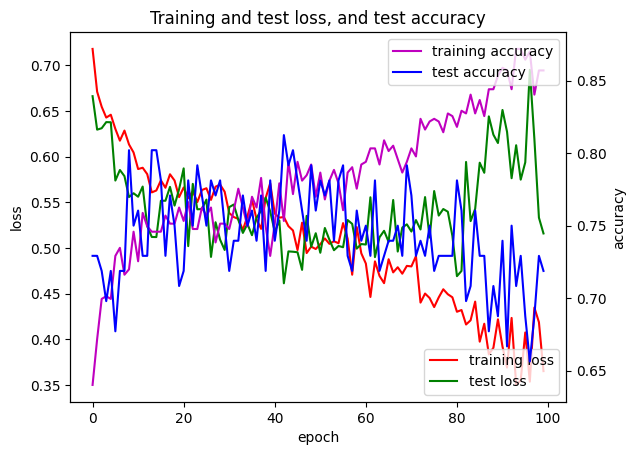

In [ ]:

device = torch.device('cuda:0')
show_graph(path ="./result/3multibranch_2000pt_test.pt",device = "cuda")

In [ ]:

pointnet_copy = PointNet_3Multihead_withDNN(classes=2)
model_path = "./pointnet_3branch_modal_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v2,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)



draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_3branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_3branch_CM")
print_values (y_true, y_pred_result)

FileNotFoundError: [Errno 2] No such file or directory: './pointnet_3branch_modal_2000pt.pth'

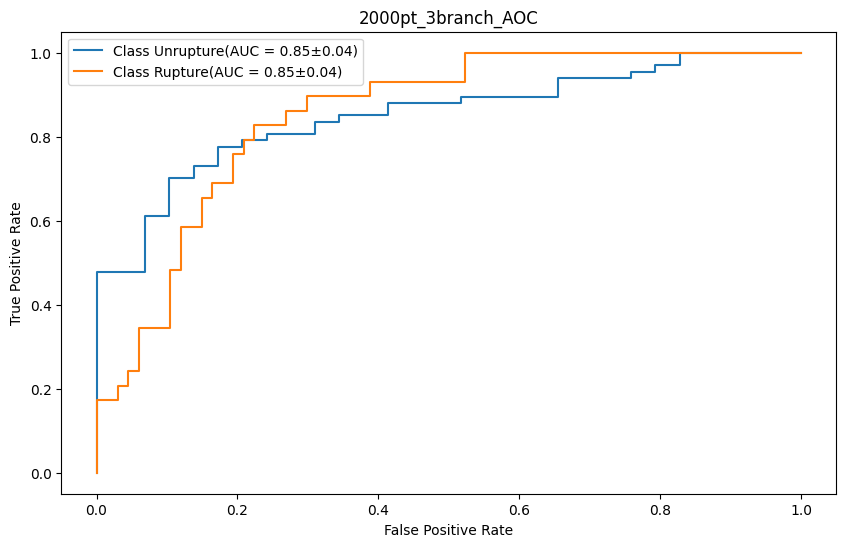

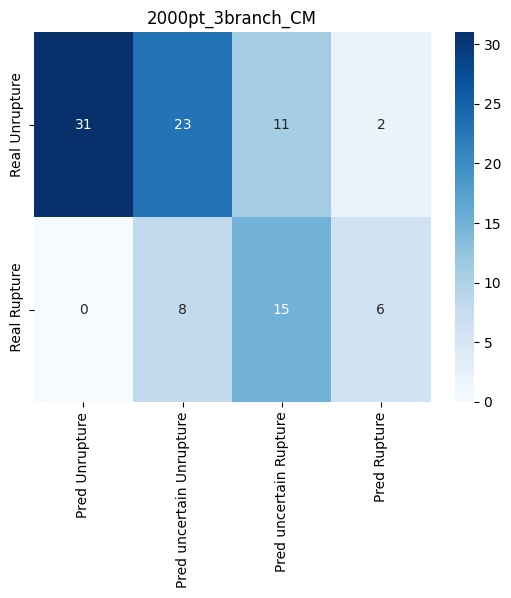

Accuracy: 0.78125
F1 score: 0.6666666666666667
Rupture Recall: 0.7241379310344828
Rupture Precision: 0.6176470588235294
UnRupture Recall: 0.8059701492537313
UnRupture Precision: 0.8709677419354839


In [ ]:

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v2,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_3branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_3branch_CM")
print_values (y_true, y_pred_result)